# Sphering Transform, Basic Example

Example [sphering transform](https://en.wikipedia.org/wiki/Whitening_transformation). For our application we are picking a full rank one, which also means we do not depend as strongly on ordering the singular values.

In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# our python modules
from sphering_transform import SpheringTransform
from distribution_diff import DistCalculator 

rng = np.random.default_rng(2023)


## Build Example Data

Data is primarily aligned to the `x=y` axis, with a small perpendicular component.

In [2]:
# build some example data 
def generate_ellipse(n_rows: int, mix: float = 1e-2):
    # build some example data
    v1 = rng.normal(size=n_rows)
    v2 = rng.normal(size=n_rows)
    d = pd.DataFrame({
        'x': v1,
        'y': v1 + mix * v2,
    })
    return d

In [3]:
# build some example data (training and holdout)
n_rows = 200

d_train = generate_ellipse(n_rows)
d_test = generate_ellipse(n_rows)

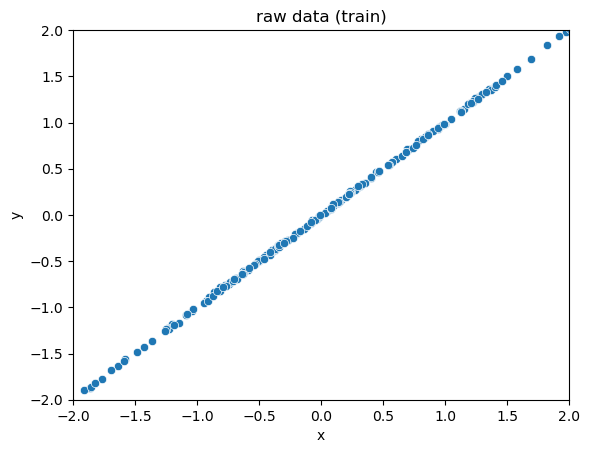

In [4]:
sns.scatterplot(
    data=d_train,
    x='x',
    y='y',
)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.title("raw data (train)")
plt.show()

## Fit the sphering transform

The sphering transform maps the data into a space where its distribution is a sphere:
* the expected norm of each transformed datum is 1
* the outer product of the transfomed data set is proportional to the identity matrix (assuming the original data was full rank)

In [5]:
st = SpheringTransform()
st.fit(d_train)

In [6]:
# transform the training data
xformed_train = st.transform(d_train)


The transformed data will look more like a sphere.

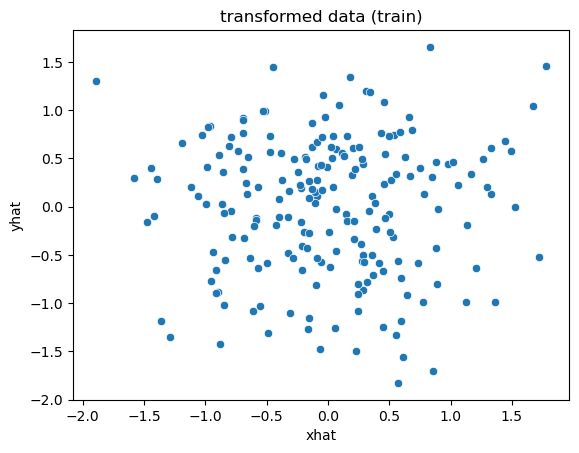

In [7]:

sns.scatterplot(
    data=pd.DataFrame(xformed_train, columns=['xhat', 'yhat']),
    x='xhat',
    y='yhat',
)

plt.title("transformed data (train)")
plt.show()

The outer product should look like a constant times the identity matrix (the constant being number of rows/ number of dimensions).

If the original data is rank deficient, this outer product will also be rank deficient. However *our transform* itself is not deficient, but full rank. It also centers the transformed data at the origin.

In [8]:
# should be proportional to the identity matrix
xformed_train.transpose() @ xformed_train

array([[ 1.00004904e+02, -6.15051449e-12],
       [-6.15051449e-12,  9.99950956e+01]])

In [9]:
# should be the origin
np.mean(xformed_train, axis=0)

array([1.97064587e-17, 1.54182223e-15])

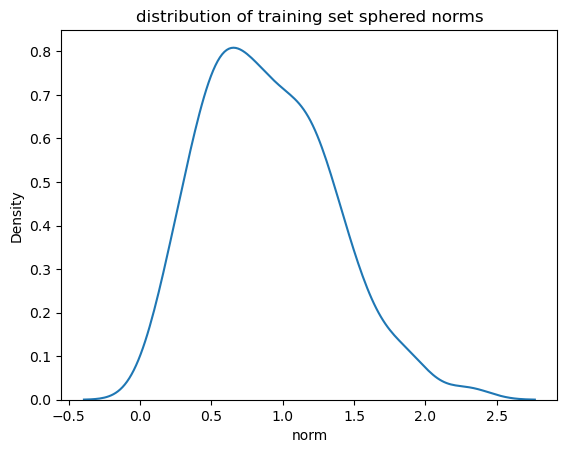

In [11]:
# plot the distribution of the norms of the transformed data
xformed_train_norms = norm(xformed_train, axis=1)

sns.kdeplot(
    data = pd.DataFrame({'norm': xformed_train_norms}),
    x='norm'
)

plt.title("distribution of training set sphered norms")
plt.show()


## Transform the holdout set and compare the distribution of its norm in transform space

As an application, we also calculate the divergence (or distance) of the two norm distributions using the Population Stability Index (you can use your preferred divergence metric).


In [12]:
xformed_test = st.transform(d_test)
xformed_test_norms = norm(xformed_test, axis=1)

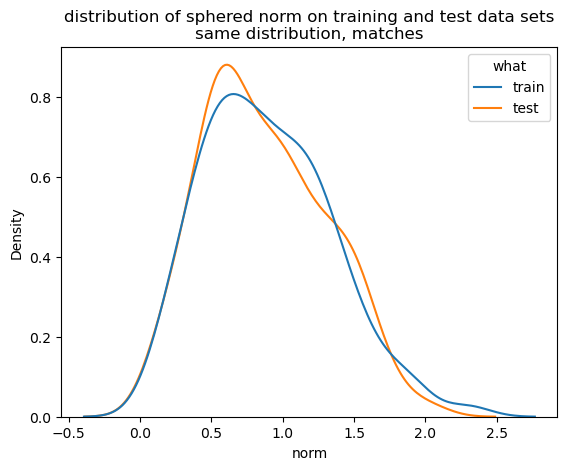

In [13]:
comparison_frame = pd.concat([
    pd.DataFrame({
        'norm': xformed_train_norms,
        'what': "train",
    }),
    pd.DataFrame({
        'norm': xformed_test_norms,
        'what': "test",
    })
])

sns.kdeplot(
    data=comparison_frame,
    x="norm",
    hue="what",
    common_norm=False,
)
plt.title("distribution of sphered norm on training and test data sets\nsame distribution, matches")
plt.show()

This PSI calculator uses decile binning. A common rule of thumb:

* PSI < 0.1: distributions are similar
* PSI between 0.1 and 0.25: distributions are somewhat different
* PSI > 0.25: distributions are very different

In [20]:
# create a PSI calculator to measure differences from xformed_train
psicalc = DistCalculator(xformed_train_norms)
print(f'PSI of holdout set with respect to reference (training set): {psicalc.PSI(xformed_test_norms)}')

PSI of holdout set with respect to reference (training set): 0.033163972739635936


## Generate a data set with a larger perpendicular component.

To the eye, the distributions don't look too different in the original space.

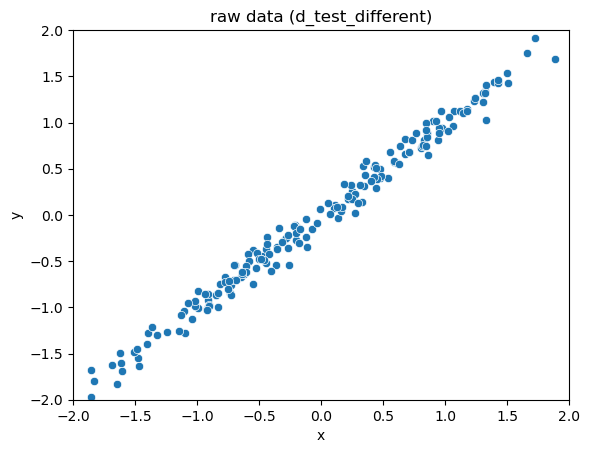

In [15]:
d_test_different = generate_ellipse(n_rows, mix=0.1)

sns.scatterplot(
    data=d_test_different,
    x='x',
    y='y',
)
plt.xlim((-2, 2))
plt.ylim((-2, 2))
plt.title("raw data (d_test_different)")
plt.show()


### Compare the distributions of the data norms in *the original* data space

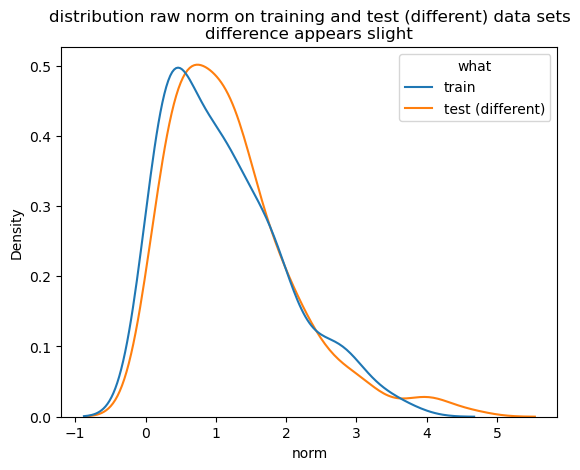

In [16]:

comparison_frame = pd.concat([
    pd.DataFrame({
        'norm': norm(d_train, axis=1),
        'what': "train",
    }),
    pd.DataFrame({
        'norm': norm(d_test_different, axis=1),
        'what': "test (different)",
    })
])

sns.kdeplot(
    data=comparison_frame,
    x="norm",
    hue="what",
    common_norm=False,
)
plt.title("distribution raw norm on training and test (different) data sets\ndifference appears slight")
plt.show()

The PSI calculator doesn't strongly flag the difference either.

In [17]:
# create a PSI calculator to measure differences from d_train
psicalc = DistCalculator(norm(d_train, axis=1))
print(f'PSI of new data set with respect to reference (training set), in original space: {psicalc.PSI(norm(d_test_different, axis=1))}')

PSI of new data set with respect to reference (training set), in original space: 0.0860492525333545


### Compare the distributions of the data norms in the sphere-transformed space

If the new data set is sphere-transformed, then the difference stands out.

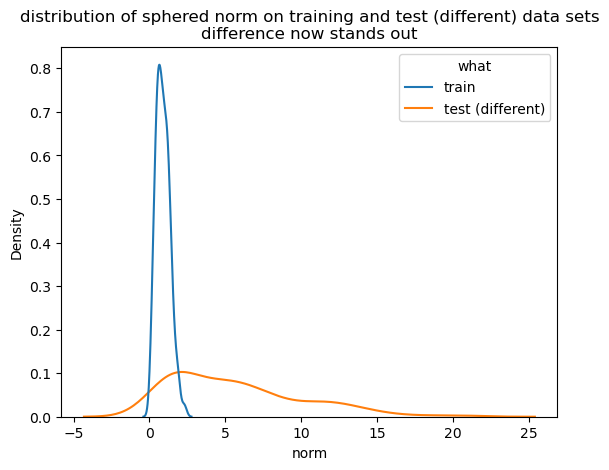

In [18]:
xformed_test_different = st.transform(d_test_different)
xformed_test_different_norms = norm(xformed_test_different, axis=1)

comparison_frame = pd.concat([
    pd.DataFrame({
        'norm': xformed_train_norms,
        'what': "train",
    }),
    pd.DataFrame({
        'norm': xformed_test_different_norms,
        'what': "test (different)",
    })
])

sns.kdeplot(
    data=comparison_frame,
    x="norm",
    hue="what",
    common_norm=False,
)
plt.title("distribution of sphered norm on training and test (different) data sets\ndifference now stands out")
plt.show()

In [28]:
# create a PSI calculator to measure differences from xformed_train
psicalc = DistCalculator(xformed_train_norms)

# compare the PSI scores of two test sets with respect to the training distribution
# This PSI calculator uses decile binning. A common rule of thumb:

# * PSI < 0.1: distributions are similar
# * PSI between 0.1 and 0.25: distributions are somewhat different
# * PSI > 0.25: distributions are very different


{
    'PSI_test': psicalc.PSI(xformed_test_norms),
    'PSI_test_different' : psicalc.PSI(xformed_test_different_norms)
}


{'PSI_test': 0.033163972739635936, 'PSI_test_different': 2.8313361193595794}

In this case, the difference in transform space is dramatic because we introduced more variation into a direction of the data where the reference data did not vary much. The difference won't always be this dramatic, but this example demonstrates how the sphering transform might be used to monitor for and detect changes in a multivariable data process.